## DeFungi Classification

#### Data Collection and Provenance

This analysis will use the DeFungi dataset from the UCI Machine Learning Repository. This particular dataset is contains microscopic images of fungi from superficial infections caused by yeasts, molds, and dermatophyte fungi. The images are organized into five classes, and each one was manually labeled with help from an expert in the field. Before the dataset was finalized, the images were cropped using automated algorithms. This makes sure that the data is not only relevant but also accurate for analysis.

#### Problem Statement

Accurately diagnosing fungal infections is challenging and often leads to ineffective treatments. Using the DeFungi dataset, the aim is to develop a model that can quickly and accurately classify microscopic images of fungi into their correct classes. This model could significantly improve diagnosis speed and accuracy, leading to better patient outcomes.

In [59]:
from PIL import Image
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

### Exploritory Data Analysis

In [14]:
# Define path to main directory
main_directory = 'class_labels'

In [10]:
# Initialize a dictionary to hold the class counts
image_counts = {}

for class_name in os.listdir(main_directory):
    class_dir = os.path.join(main_directory, class_name)
    
    if os.path.isdir(class_dir):
        num_images = len([img for img in os.listdir(class_dir) if img.endswith('.jpg')])
        image_counts[class_name] = num_images

# Print the results
for class_name, count in image_counts.items():
    print(f"Class '{class_name}' has {count} images.")

Class 'H2' has 2334 images.
Class 'H5' has 818 images.
Class 'H3' has 819 images.
Class 'H6' has 739 images.
Class 'H1' has 4404 images.


In [11]:
# Initialize a set to hold unique image sizes
image_sizes = set()

for class_name in os.listdir(main_directory):
    class_dir = os.path.join(main_directory, class_name)
    
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith('.jpg'):
                with Image.open(img_path) as img:
                    image_sizes.add(img.size)

# Print the unique image sizes
print("Unique image sizes in the dataset:")
for size in image_sizes:
    print(size)

Unique image sizes in the dataset:
(500, 500)


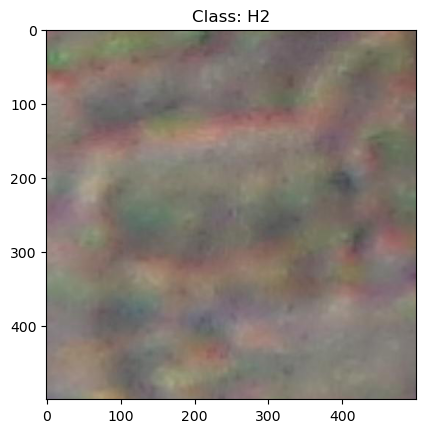

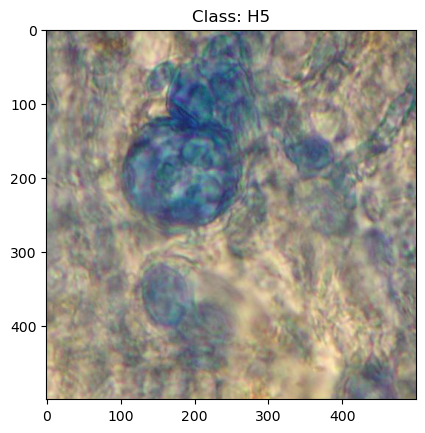

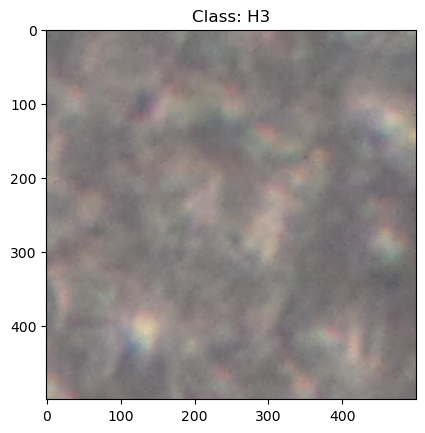

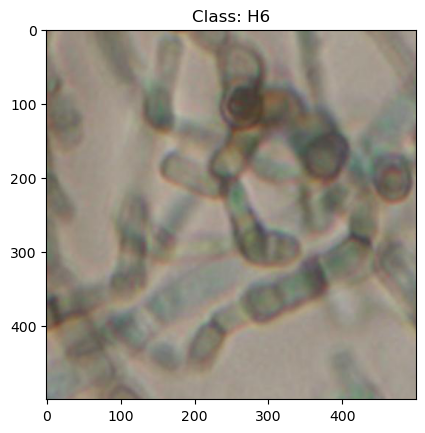

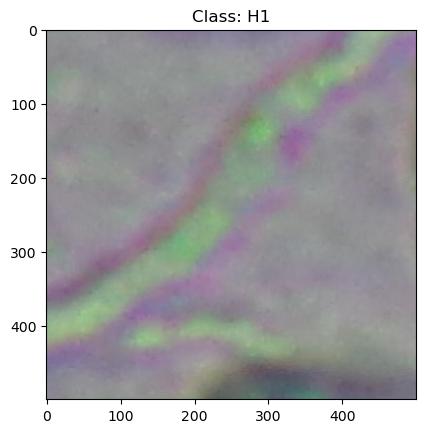

In [15]:
# Visualize images from each class
for class_name in os.listdir(main_directory):
    class_dir = os.path.join(main_directory, class_name)
    
    if os.path.isdir(class_dir):
        img_name = os.listdir(class_dir)[0]  
        img_path = os.path.join(class_dir, img_name)
        
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.show()

The dataset consists of images from five classes with varying quantities: 'H2' has 2,334 images, 'H5' has 818 images, 'H3' has 819 images, 'H6' has 739 images, and 'H1' has the largest count with 4,404 images. The handling of the imbalanced classes will be discussed throughout the data preparation process, as well as during the analysis of the different models. All images in the dataset share a uniform size of 500x500 pixels.

### Data Preperation and Clearning

In the data preparation process, the first step was to split the dataset into training and validation sets to ensure proper model evaluation. Given the class imbalance in the dataset, where some classes had significantly more images than others, data augmentation techniques were applied to the training set using ImageDataGenerator. This included random rotations, shifts, zooms, and horizontal flips, which increased the diversity of the images in the minority classes and helped balance the dataset without artificially inflating the number of images.

For the training set, ImageDataGenerator was used to both augment and preprocess the images, making the model more robust by exposing it to a wider variety of image variations. The validation set, on the other hand, was processed with basic rescaling to ensure that the validation results reflected the model’s performance on unaltered images.

Overall, this approach ensured that the models were trained on a balanced and varied dataset, improving its robustness and performance on unseen data.

In [18]:
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_directory(
    main_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Explore a batch of images
images, labels = next(generator)
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Found 9114 images belonging to 5 classes.
Batch shape: (32, 150, 150, 3)
Labels shape: (32, 5)


In [20]:
# Define a data generator for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set the validation split (e.g., 20% of training data used for validation)
)

In [22]:
train_generator = train_datagen.flow_from_directory(
    main_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify this is the training subset
)

Found 7295 images belonging to 5 classes.


In [28]:
validation_generator = train_datagen.flow_from_directory(
    main_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify this is the validation subset
)

Found 1819 images belonging to 5 classes.


### Begininning Model Architecture

The model architecture consists of three convolutional layers with ReLU activation and increasing filter sizes (32, 64, 128), each followed by max-pooling layers to reduce spatial dimensions and computational complexity. These layers have the ability to learn spatial hierarchies of features. The use of ReLU activation introduces non-linearity, allowing the model to capture more complex patterns in the images.

After flattening the output from the convolutional layers, the model has a dense layer with 128 neurons and ReLU activation, followed by a single neuron with a sigmoid activation for binary classification. This combination allows the model to effectively combine and classify the features extracted from the images, outputting a probability score indicating the presence or absence of cancer. The choice of architecture was intended to balance complexity and efficiency. 

In [29]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # Adjust output layer size to match your number of classes
])

In [39]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall()])

In [40]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=6,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/6
227/227 [==============================] - 172s 753ms/step - loss: 0.8796 - accuracy: 0.6445 - precision: 0.7084 - recall: 0.5338 - val_loss: 1.0329 - val_accuracy: 0.5731 - val_precision: 0.6701 - val_recall: 0.5145
Epoch 2/6
227/227 [==============================] - 179s 789ms/step - loss: 0.8630 - accuracy: 0.6523 - precision: 0.7124 - recall: 0.5589 - val_loss: 1.0647 - val_accuracy: 0.5792 - val_precision: 0.6343 - val_recall: 0.5246
Epoch 3/6
227/227 [==============================] - 176s 774ms/step - loss: 0.8563 - accuracy: 0.6570 - precision: 0.7083 - recall: 0.5641 - val_loss: 1.0684 - val_accuracy: 0.5664 - val_precision: 0.6272 - val_recall: 0.4939
Epoch 4/6
227/227 [==============================] - 170s 748ms/step - loss: 0.8386 - accuracy: 0.6563 - precision: 0.7127 - recall: 0.5722 - val_loss: 1.0910 - val_accuracy: 0.5859 - val_precision: 0.6569 - val_recall: 0.4989
Epoch 5/6
227/227 [==============================] - 172s 757ms/step - loss: 0.8335 - accura

In [41]:
# Calculate the validation loss and accuracy for the first model
val_loss, val_acc, val_precision, val_recall = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc:.2f}')
print(f'Validation Precision: {val_precision:.2f}')
print(f'Validation Recall: {val_recall:.2f}')

57/57 [==============================] - 19s 328ms/step - loss: 1.1594 - accuracy: 0.5866 - precision: 0.6290 - recall: 0.5415
Validation Accuracy: 0.59
Validation Precision: 0.63
Validation Recall: 0.54


In [42]:
# Assuming `validation_generator` is your validation data generator
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

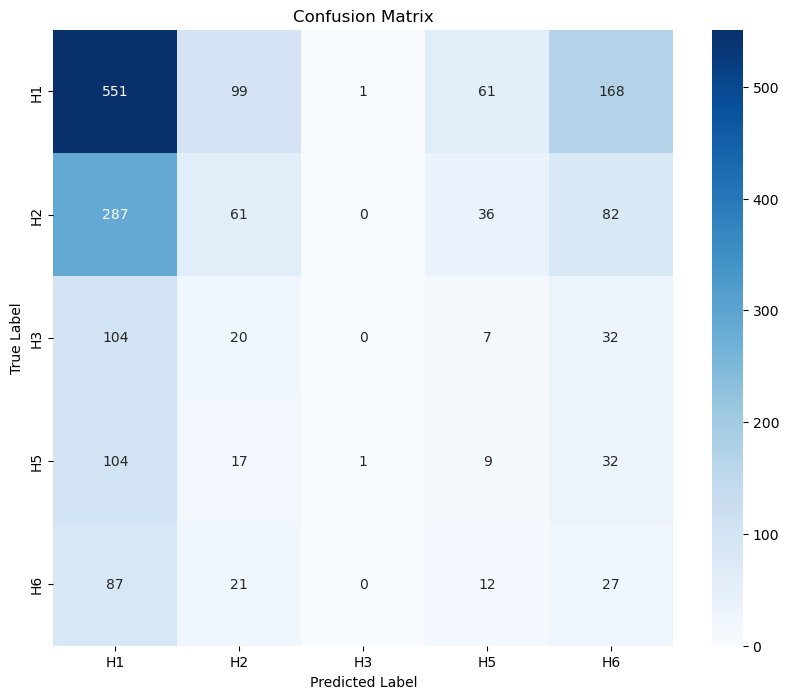

In [43]:
# Generate the confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# Generate the classification report
report = classification_report(validation_generator.classes, y_pred, target_names=list(validation_generator.class_indices.keys()))

print(report)

              precision    recall  f1-score   support

          H1       0.49      0.63      0.55       880
          H2       0.28      0.13      0.18       466
          H3       0.00      0.00      0.00       163
          H5       0.07      0.06      0.06       163
          H6       0.08      0.18      0.11       147

    accuracy                           0.36      1819
   macro avg       0.18      0.20      0.18      1819
weighted avg       0.32      0.36      0.33      1819



#### Model 1: Results and Analysis

The model's performance across most classes is suboptimal. Class 'H1' shows the best results, with a precision of 0.49, recall of 0.63, and an F1-score of 0.55, indicating that the model is somewhat effective at identifying instances of this class. However, the performance drops significantly for other classes such as 'H2', 'H3', 'H5', and 'H6', with particularly poor results for class 'H3', where the F1-score is 0.00, meaning the model failed to correctly classify any instances of this class.

Overall, the model achieves an accuracy of 36%, and this is reflected in the macro and weighted averages, which also indicate low performance, with F1-scores of 0.18 and 0.33, respectively. These results suggest that the model is struggling, particularly with the underrepresented classes, highlighting a need for further refinement and potentially addressing class imbalance more effectively.

To address the class imbalance, images from the minority classes were manually duplicated in their respective directories to equalize the number of images across all classes. After balancing the dataset in this way, the data processing and cleaning steps were repeated with the newly balanced classes. This ensured that the model had a more even representation of each class during training, potentially improving its ability to correctly classify instances from all categories.

In [45]:
# Initialize a dictionary to hold the counts
image_counts = {}

for class_name in os.listdir(main_directory):
    class_dir = os.path.join(main_directory, class_name)
    
    if os.path.isdir(class_dir):
        num_images = len([img for img in os.listdir(class_dir) if img.endswith('.jpg')])
        image_counts[class_name] = num_images

# Print the results
for class_name, count in image_counts.items():
    print(f"Class '{class_name}' has {count} images.")

Class 'H2' has 4668 images.
Class 'H5' has 4090 images.
Class 'H3' has 4914 images.
Class 'H6' has 5912 images.
Class 'H1' has 4404 images.


In [46]:
datagen_balanced = ImageDataGenerator(rescale=1./255)
generator_balanced = datagen_balanced.flow_from_directory(
    main_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Explore a batch of images
images_balanced, labels_balanced = next(generator_balanced)
print(f"Batch shape: {images_balanced.shape}")
print(f"Labels shape: {labels_balanced.shape}")

Found 23988 images belonging to 5 classes.
Batch shape: (32, 150, 150, 3)
Labels shape: (32, 5)


In [47]:
# Define a data generator for the training set
train_datagen_balanced = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

In [48]:
train_generator_balanced = train_datagen_balanced.flow_from_directory(
    main_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

Found 19193 images belonging to 5 classes.


In [49]:
validation_generator_balanced = train_datagen_balanced.flow_from_directory(
    main_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation' 
)

Found 4795 images belonging to 5 classes.


The same model architecture was used with the newly balanced classes to allow for a direct comparison with the original model. By keeping the architecture consistent, it is easy to accurately assess the impact of balancing the classes on the model's performance, providing clear insights into how addressing class imbalance influenced the classification results.

In [50]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  
])

In [51]:
model_2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall()])

In [53]:
# Train the model
model_2.fit(
    train_generator_balanced,
    steps_per_epoch=train_generator_balanced.samples // train_generator_balanced.batch_size,
    epochs=6,
    validation_data=validation_generator_balanced,
    validation_steps=validation_generator_balanced.samples // validation_generator_balanced.batch_size
)

Epoch 1/6
599/599 [==============================] - 423s 706ms/step - loss: 1.0442 - accuracy: 0.5791 - precision_1: 0.7079 - recall_1: 0.3983 - val_loss: 1.2290 - val_accuracy: 0.5078 - val_precision_1: 0.6266 - val_recall_1: 0.4203
Epoch 2/6
599/599 [==============================] - 424s 707ms/step - loss: 0.9266 - accuracy: 0.6261 - precision_1: 0.7298 - recall_1: 0.4938 - val_loss: 1.2388 - val_accuracy: 0.5122 - val_precision_1: 0.6499 - val_recall_1: 0.4146
Epoch 3/6
599/599 [==============================] - 434s 725ms/step - loss: 0.8453 - accuracy: 0.6578 - precision_1: 0.7500 - recall_1: 0.5385 - val_loss: 1.2049 - val_accuracy: 0.5050 - val_precision_1: 0.5606 - val_recall_1: 0.4037
Epoch 4/6
599/599 [==============================] - 465s 776ms/step - loss: 0.7690 - accuracy: 0.6873 - precision_1: 0.7629 - recall_1: 0.5854 - val_loss: 1.0125 - val_accuracy: 0.5805 - val_precision_1: 0.6531 - val_recall_1: 0.5031
Epoch 5/6
599/599 [==============================] - 526s 87

In [54]:
# Calculate the validation loss and accuracy for the first model
val_loss_2, val_acc_2, val_precision_2, val_recall_2 = model_2.evaluate(validation_generator_balanced)
print(f'Validation Accuracy: {val_acc_2:.2f}')
print(f'Validation Precision: {val_precision_2:.2f}')
print(f'Validation Recall: {val_recall_2:.2f}')

150/150 [==============================] - 56s 371ms/step - loss: 1.1781 - accuracy: 0.5852 - precision_1: 0.6327 - recall_1: 0.5364
Validation Accuracy: 0.59
Validation Precision: 0.63
Validation Recall: 0.54


In [55]:
# Assuming `validation_generator` is your validation data generator
Y_pred_2 = model_2.predict(validation_generator_balanced)
y_pred_2 = np.argmax(Y_pred_2, axis=1)

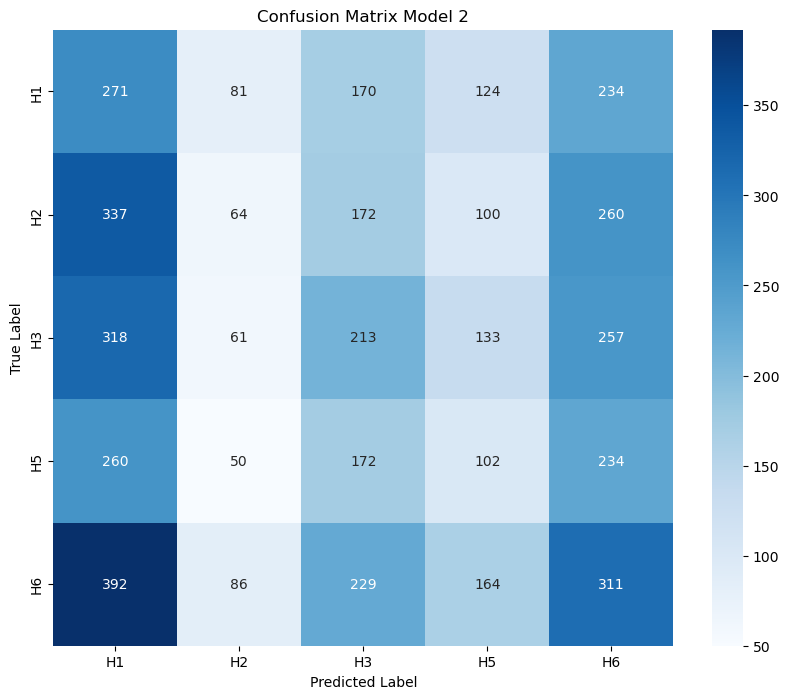

In [56]:
# Generate the confusion matrix
cm_2 = confusion_matrix(validation_generator_balanced.classes, y_pred_2)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator_balanced.class_indices.keys(), yticklabels=validation_generator_balanced.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix Model 2')
plt.show()

In [57]:
# Generate the classification report
report_2 = classification_report(validation_generator_balanced.classes, y_pred_2, target_names=list(validation_generator_balanced.class_indices.keys()))

print(report_2)

              precision    recall  f1-score   support

          H1       0.17      0.31      0.22       880
          H2       0.19      0.07      0.10       933
          H3       0.22      0.22      0.22       982
          H5       0.16      0.12      0.14       818
          H6       0.24      0.26      0.25      1182

    accuracy                           0.20      4795
   macro avg       0.20      0.20      0.19      4795
weighted avg       0.20      0.20      0.19      4795



#### Model 2: Results and Analysis

After balancing the classes, the model's performance showed a shift, particularly in its ability to recognize minority classes. In the original model, class H1 had the highest performance, with a precision of 0.49 and an F1-score of 0.55. However, after balancing the classes, the performance for H1 dropped significantly, with precision falling to 0.17 and the F1-score to 0.22. This indicates that the model’s ability to correctly classify instances of H1 decreased after balancing the dataset.

On the other hand, the balanced model showed improvements for some of the minority classes. For instance, the F1-score for class H3 improved from 0.00 in the original model to 0.22 after balancing, suggesting that the model became better at recognizing instances of this underrepresented class. Similar improvements were seen in class H6, where the F1-score increased from 0.11 to 0.25.

Overall, while the balanced model was better at detecting some of the minority classes, it came at the cost of overall accuracy, which dropped from 36% to 20%. The macro and weighted average F1-scores remained similar, indicating that the improvements in some classes were offset by declines in others. This suggests that while class balancing can help with underrepresented classes, it may require further refinement to achieve a better overall performance.

### Updated Model Architecture 

The next step in this approach was to introduce batch normalization into the model. This technique was added to see if it could help stabilize and improve the accuracy, especially after the mixed results we observed with the balanced classes. By normalizing the activations in each layer, batch normalization can reduce internal covariate shift, potentially leading to faster convergence during training and better overall model performance. The hope is that this adjustment will enhance the model’s ability to generalize across all classes, boosting accuracy while maintaining improvements in the minority categories.

In [64]:
#Define model
model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  
])

In [65]:
# Compile the model
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [66]:
# Train the model
model_3.fit(
    train_generator_balanced,
    steps_per_epoch=train_generator_balanced.samples // train_generator_balanced.batch_size,
    epochs=6,
    validation_data=validation_generator_balanced,
    validation_steps=validation_generator_balanced.samples // validation_generator_balanced.batch_size
)

Epoch 1/6
599/599 [==============================] - 560s 933ms/step - loss: 0.5258 - accuracy: 0.5985 - precision_3: 0.6439 - recall_3: 0.5401 - val_loss: 0.8063 - val_accuracy: 0.2926 - val_precision_3: 0.2967 - val_recall_3: 0.2687
Epoch 2/6
599/599 [==============================] - 589s 983ms/step - loss: 0.2841 - accuracy: 0.6670 - precision_3: 0.7375 - recall_3: 0.5956 - val_loss: 0.4222 - val_accuracy: 0.4323 - val_precision_3: 0.5401 - val_recall_3: 0.3513
Epoch 3/6
599/599 [==============================] - 628s 1s/step - loss: 0.2646 - accuracy: 0.6871 - precision_3: 0.7534 - recall_3: 0.6282 - val_loss: 0.8538 - val_accuracy: 0.3521 - val_precision_3: 0.3568 - val_recall_3: 0.3427
Epoch 4/6
599/599 [==============================] - 608s 1s/step - loss: 0.2460 - accuracy: 0.7157 - precision_3: 0.7720 - recall_3: 0.6641 - val_loss: 0.7764 - val_accuracy: 0.3796 - val_precision_3: 0.3916 - val_recall_3: 0.3660
Epoch 5/6
599/599 [==============================] - 563s 939ms/st

In [67]:
# Calculate the validation loss and accuracy for the first model
val_loss_3, val_acc_3, val_precision_3, val_recall_3 = model_3.evaluate(validation_generator_balanced)
print(f'Validation Accuracy: {val_acc_3:.2f}')
print(f'Validation Precision: {val_precision_3:.2f}')
print(f'Validation Recall: {val_recall_3:.2f}')

150/150 [==============================] - 61s 409ms/step - loss: 0.8429 - accuracy: 0.4015 - precision_3: 0.4048 - recall_3: 0.3929
Validation Accuracy: 0.40
Validation Precision: 0.40
Validation Recall: 0.39


In [68]:
# Assuming `validation_generator` is your validation data generator
Y_pred_3 = model_3.predict(validation_generator_balanced)
y_pred_3 = np.argmax(Y_pred_3, axis=1)

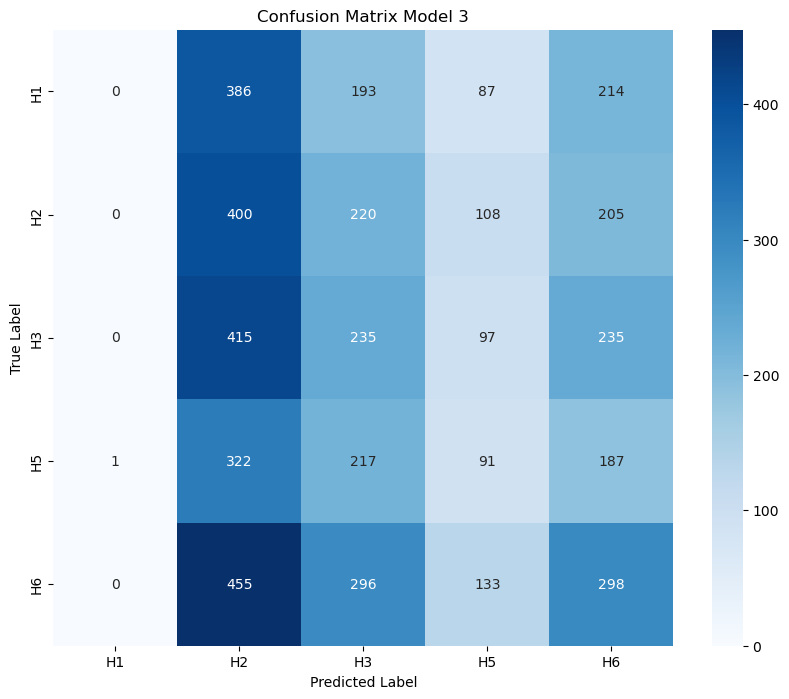

In [69]:
# Generate the confusion matrix
cm_3 = confusion_matrix(validation_generator_balanced.classes, y_pred_3)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator_balanced.class_indices.keys(), yticklabels=validation_generator_balanced.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix Model 3')
plt.show()

In [70]:
# Generate the classification report
report_3 = classification_report(validation_generator_balanced.classes, y_pred_3, target_names=list(validation_generator_balanced.class_indices.keys()))

print(report_3)

              precision    recall  f1-score   support

          H1       0.00      0.00      0.00       880
          H2       0.20      0.43      0.27       933
          H3       0.20      0.24      0.22       982
          H5       0.18      0.11      0.14       818
          H6       0.26      0.25      0.26      1182

    accuracy                           0.21      4795
   macro avg       0.17      0.21      0.18      4795
weighted avg       0.18      0.21      0.18      4795



#### Model 3: Results and Analysis

Introducing batch normalization into the model produced mixed results, with some notable improvements but also significant drawbacks. The most concerning change was in class H1, where performance dropped to zero across all metrics—precision, recall, and F1-score. This is a sharp decline from both the original model and the balanced model, indicating that batch normalization negatively impacted the model’s ability to classify instances of H1 effectively.

On the other hand, class H2 showed improvement, particularly in recall, which increased to 0.43 from 0.07 in the balanced model. The F1-score for H2 also improved, suggesting that batch normalization helped the model better identify instances of this class. However, for other classes like H3, H5, and H6, the results remained relatively stable compared to the balanced model, with only slight variations in performance.

Overall, the model’s accuracy remained virtually unchanged at 21%, similar to the results before introducing batch normalization. The macro and weighted average F1-scores also stayed consistent, indicating that while batch normalization provided some benefits, it did not lead to a significant overall improvement. This suggests that while batch normalization can enhance certain aspects of model performance, its effectiveness may vary depending on the specific data and model configuration, and further adjustments may be necessary to achieve better results.

### Conclusions

Throughout this effort to improve the image classification model, persistent challenges were encountered, and none of the approaches produced strong results. Initially, the model performed reasonably well on the majority class (H1) but struggled with the minority classes due to significant class imbalance.

To address this, the dataset was balanced manually by duplicating images from the minority classes. While this led to better recognition of these classes, it also caused a drop in overall accuracy, particularly affecting the majority class. Introducing batch normalization offered some improvement for class H2 but severely impacted class H1, resulting in minimal overall gains.

These outcomes suggest that more sophisticated strategies are needed. Potential next steps include advanced data augmentation, adjusting class weights during training, experimenting with more complex model architectures, or employing ensemble methods to combine the strengths of multiple models.

While none of the models performed particularly well, these trials provided valuable insights into the challenges of class imbalance and the importance of careful model tuning, which will guide further experimentation.

### References

Hajati,Farshid, Javier Pineda Sopo,Camilo, Hajati,Farshid, and Gheisari,Soheila. (2023). DeFungi. UCI Machine Learning Repository. https://doi.org/10.48550/arXiv.2109.07322.

TensorFlow. (n.d.). Convolutional neural network (CNN). TensorFlow. Retrieved August 16, 2024, from https://www.tensorflow.org/tutorials/images/cnn